# Predictor de Popularidade de Músicas

**Índice**<a id='toc0_'></a>    
1. [Introdução](#toc1_)    
2. [Preparação do notebook para R e Python em sumultâneo](#toc2_)    
3. [Importação dos módulos](#toc3_)    
4. [Exploração dos dados em bruto](#toc4_)    
4.1. [Upload dos dados](#toc4_1_)    
4.2. [Criação do dataframe](#toc4_2_)    
4.3. [Visualização do dataframe em bruto e de algumas métricas](#toc4_3_)    
5. [Análise Exploratória](#toc5_)    
5.1. [Distribuição dos valores em cada coluna](#toc5_1_)    
6. [Pré-processamento dos dados](#toc6_)    
6.1. [Identificação de Valores Ausentes](#toc6_1_)    
6.2. [Remoção de musicas com tempo 0](#toc6_2_)    
6.3. [Identificação e remoção de duplicados](#toc6_3_)    
6.4. [Definir o índice](#toc6_4_)    
6.5. [Remover coluna song_name](#toc6_5_)    
6.6. [Definir variáveis categóricas e variáveis numéricas](#toc6_6_)    
6.7. [Método do intervalo interquartil (IQR) para filtrar outliers](#toc6_7_)    
6.8. [Remoção de outliers com o z-score](#toc6_8_)    
6.9. [Remoção de outliers com Local Outlier Factor (LOF)](#toc6_9_)    
6.10. [Remoção de outliers variável a variável](#toc6_10_)    
6.11. [Gráficos comparativos da remoção dos outliers com os diferentes métodos](#toc6_11_)    
6.12. [Inferência](#toc6_12_)    
6.13. [Estatísticas do dataset](#toc6_13_)    
7. [Implementação de algoritmos de Aprendizagem Computacional](#toc7_)    
7.1. [Random Forest](#toc7_1_)    
7.1.1. [Divisão das variáveis dependentes e independentes](#toc7_1_1_)    
7.1.2. [Divisão em conjunto de treino e conjunto de teste](#toc7_1_2_)    
7.1.3. [Treino inicial do modelo](#toc7_1_3_)    
7.1.4. [Esquema árvore](#toc7_1_4_)    
7.1.5. [Performance](#toc7_1_5_)    
7.1.6. [Matriz de confusão](#toc7_1_6_)    
7.1.7. [Afinação dos hiperparâmetros com o Grid Search Cross Validation](#toc7_1_7_)    
7.1.8. [Configurar e executar o Grid Search Cross Validation](#toc7_1_8_)    
7.1.9. [Treino do modelo com os melhores hiperparâmetros](#toc7_1_9_)    
7.2. [Árvore de Regressão](#toc7_2_)    
7.2.1. [Existem diferentes pacotes para modelar com árvores de decisão. Aqui usaremos o tree.](#toc7_2_1_)    
7.2.2. [Vamos dividir o conjunto de dados em dados de treio e de teste.](#toc7_2_2_)    
7.2.3. [Ajustamos uma árvore de regressão:](#toc7_2_3_)    
7.2.4. [O PROCESSO DE PODA](#toc7_2_4_)    
7.2.5. [A ÁRVIRE TMAX](#toc7_2_5_)    
7.2.6. [A PODA DA ÁRVIRE TMAX](#toc7_2_6_)    
7.3. [Bagging](#toc7_3_)    
8. [Resultados](#toc8_)    
9. [Considerações finais](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introdução](#toc0_)

## 2. <a id='toc2_'></a>[Preparação do notebook para R e Python em sumultâneo](#toc0_)

In [121]:
# ! R -e "install.packages('IRkernel', repos = 'http://cran.us.r-project.org');IRkernel::installspec()"

In [122]:
# ! pip install rpy2

In [1]:
%load_ext rpy2.ipython

In [124]:
#%%R -i df_no_outliers
#head(df_no_outliers) #Exemplo de utilização

## 3. <a id='toc3_'></a>[Importação dos módulos](#toc0_)

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


## 4. <a id='toc4_'></a>[Exploração dos dados em bruto](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Upload dos dados](#toc0_)

In [3]:
data = pd.read_csv('data/song_data.csv')

### 4.2. <a id='toc4_2_'></a>[Criação do dataframe](#toc0_)

In [4]:
df_raw = pd.DataFrame(data)

In [5]:
df_raw

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


### 4.3. <a id='toc4_3_'></a>[Visualização do dataframe em bruto e de algumas métricas](#toc0_)

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [7]:
df_raw.shape

(18835, 15)

## 5. <a id='toc5_'></a>[Análise Exploratória](#toc0_)

### 5.1. <a id='toc5_1_'></a>[Distribuição dos valores em cada coluna](#toc0_)

In [8]:
col_names = df_raw.columns

col_names

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [9]:
col_counts = {}

for col in col_names:
    col_counts[col] = df_raw[col].value_counts()

col_counts


{'song_name': song_name
 Better                                            21
 FEFE (feat. Nicki Minaj & Murda Beatz)            19
 MIA (feat. Drake)                                 18
 Taki Taki (with Selena Gomez, Ozuna & Cardi B)    18
 No Stylist                                        17
                                                   ..
 Bassride                                           1
 The Beat                                           1
 We Are the Brave - Fatum Remix                     1
 Long Live House Music                              1
 Up to Me                                           1
 Name: count, Length: 13070, dtype: int64,
 'song_popularity': song_popularity
 58     404
 52     389
 55     388
 60     383
 63     378
       ... 
 98      47
 97      36
 93      32
 99      16
 100     12
 Name: count, Length: 101, dtype: int64,
 'song_duration_ms': song_duration_ms
 165000    25
 180000    21
 212500    20
 189000    20
 179404    19
           ..
 219682 

## 6. <a id='toc6_'></a>[Pré-processamento dos dados](#toc0_)

### 6.1. <a id='toc6_1_'></a>[Identificação de Valores Ausentes](#toc0_)

In [10]:
df_raw.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

### 6.2. <a id='toc6_2_'></a>[Remoção de musicas com tempo 0](#toc0_)

In [11]:
df_raw.drop(df_raw[(df_raw['tempo']==0)].index, inplace=True)

### 6.3. <a id='toc6_3_'></a>[Identificação e remoção de duplicados](#toc0_)

In [12]:
# Remover duplicatas considerando todas as colunas
df_raw.drop_duplicates(inplace=True)


In [13]:
df_raw.shape

(14924, 15)

### 6.4. <a id='toc6_4_'></a>[Definir o índice](#toc0_)

In [14]:
df_raw.set_index(pd.RangeIndex(start=0, stop=len(df_raw)+1, step=1), inplace=True)

### 6.5. <a id='toc6_5_'></a>[Remover coluna song_name](#toc0_)

In [15]:
df_raw.drop(columns='song_name', inplace=True)


### 6.7. <a id='toc6_7_'></a>[Método do intervalo interquartil (IQR) para filtrar outliers](#toc0_)

In [16]:
numeric_columns = df_raw.select_dtypes(include='number')

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Define os limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Identifica e remove outliers
outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)
df_IQR = df_raw[~outliers]
df_IQR.shape

(8609, 14)

### 6.8. <a id='toc6_8_'></a>[Remoção de outliers com o z-score](#toc0_)

In [17]:
# Calcular os z-scores para todas as colunas
z_scores = np.abs(stats.zscore(df_raw))

# Definir um threshold para outliers (por exemplo, Z-score < 3)
threshold = 3

# Manter as linhas onde os z-scores são menores que o threshold para todas as colunas
df_Z = df_raw[(z_scores < threshold).all(axis=1)]

In [ ]:
df_Z

### 6.9. <a id='toc6_9_'></a>[Remoção de outliers com Local Outlier Factor (LOF)](#toc0_)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Supondo que df_raw é o seu DataFrame carregado com várias colunas
# Se df_raw não estiver definido, você pode carregá-lo assim:
# df_raw = pd.read_csv('caminho/para/seu/arquivo.csv')

# Load the dataset
X = df_raw

# Create the LocalOutlierFactor model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20)

# Fit the model to the data and predict the outlier scores for each data point
outlier_scores = lof_outlier.fit_predict(X)

# Identify the outlier data points
outlier_indices = outlier_scores == -1
print("Outlier indices:", outlier_indices)

# Remover os outliers do DataFrame
df_LOF = X[~outlier_indices]
df_LOF.shape

Outlier indices: [False False False ... False False False]


(14885, 14)

In [ ]:
df_IQR

### 6.10. <a id='toc6_10_'></a>[Remoção de outliers variável a variável](#toc0_)

In [93]:
%%R

install.packages("pls")
library(pls)
library(psych) 
library(readr)
library(tree)
library(caret)
library(gbm)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(pROC)
library(ggplot2)
library(reshape2)




The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpqYzXIF/downloaded_packages


trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/pls_2.8-3.tgz'
Content type 'application/gzip' length 1183010 bytes (1.1 MB)
downloaded 1.1 MB



In [134]:
%%R -i df_raw

data = df_raw

data.numeric <- data[,sapply(data, is.numeric)]
head(data.numeric)


  song_popularity song_duration_ms acousticness danceability energy
1              73           262333     0.005520        0.496  0.682
2              66           216933     0.010300        0.542  0.853
3              76           231733     0.008170        0.737  0.463
4              74           216933     0.026400        0.451  0.970
5              56           223826     0.000954        0.447  0.766
6              80           235893     0.008950        0.316  0.945
  instrumentalness key liveness loudness audio_mode speechiness   tempo
1         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
2         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
3         4.47e-01   0   0.2550   -7.828          1      0.0792 123.881
4         3.55e-03   0   0.1020   -4.938          1      0.1070 122.444
5         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
6         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
  time_signature aud

In [135]:
%%R
#################CATEGORIZAÇÃO DOS DADOS##################

quartiles <- quantile(data$song_popularity, probs = c(0, 0.25, 0.5, 0.75, 0.95), na.rm = TRUE)
breaks <- c(quartiles[1:5], Inf)
labels <- c("Não_popular", "Pouco_popular", "Rádio_amigável", "Popular", "Viral")
data$song_category <- cut(data$song_popularity, breaks = breaks, labels = labels, include.lowest = TRUE)
summary(data$song_category)
data$song_name<-NULL
head(data)

  song_popularity song_duration_ms acousticness danceability energy
1              73           262333     0.005520        0.496  0.682
2              66           216933     0.010300        0.542  0.853
3              76           231733     0.008170        0.737  0.463
4              74           216933     0.026400        0.451  0.970
5              56           223826     0.000954        0.447  0.766
6              80           235893     0.008950        0.316  0.945
  instrumentalness key liveness loudness audio_mode speechiness   tempo
1         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
2         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
3         4.47e-01   0   0.2550   -7.828          1      0.0792 123.881
4         3.55e-03

   0   0.1020   -4.938          1      0.1070 122.444
5         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
6         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
  time_signature audio_valence  song_category
1              4         0.474        Popular
2              4         0.370        Popular
3              4         0.324        Popular
4              4         0.198        Popular
5              4         0.574 Rádio_amigável
6              4         0.320          Viral


[1] 4


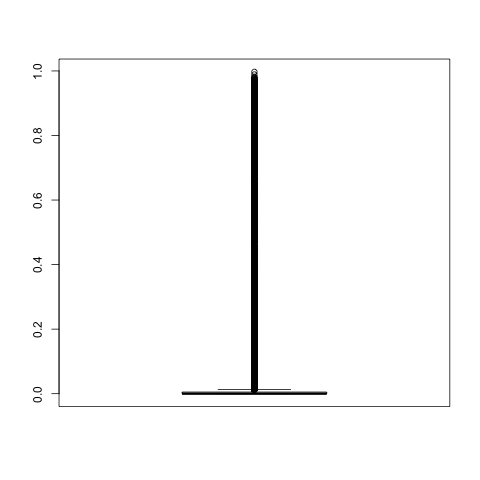

In [136]:
%%R
#################LIMPEZA DE OUTLIERS#################

boxplot(data$song_duration_ms)

boxplot(data$instrumentalness)
ggplot(data, aes(x = song_category, y = song_duration_ms)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "song_duration_ms")


threshold <- 1000000  # limite dos outliers (limite)
data <- data[data$song_duration_ms <= threshold, ]
dim(data)
18835-18831 ##4 outliers eliminados

In [137]:
%%R
#####Variavel acousticness

ggplot(data, aes(x = song_category, y = acousticness)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Acousticness")

# Definir o limite (threshold)
threshold1 <- 0.98
data <- data[!(data$song_category == "Popular" & data$acousticness > threshold1), ]
head(data)
18835-18814 ##21 outliers eliminados

[1]

 21


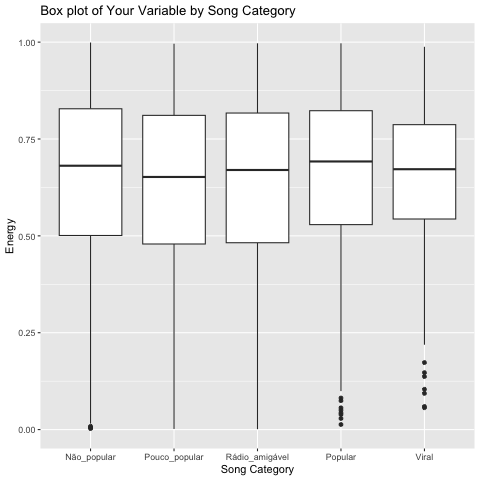

In [138]:
%%R
#####Variavel Energy
##Não é preciso eliminar outliers

ggplot(data, aes(x = song_category, y = energy
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Energy")


In [139]:
%%R
#####Variavel Speechiness

ggplot(data, aes(x = song_category, y = speechiness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Speechiness")

threshold1 <- 0.9  
threshold2 <- 0.9 
threshold3 <- 0.75
threshold4 <- 0.5
data <- data[!(data$song_category == "Not_popular" & data$speechiness > threshold1), ]
data <- data[!(data$song_category == "Low_popularity" & data$speechiness > threshold2), ]
data <- data[!(data$song_category == "Radio_friendly" & data$speechiness > threshold3), ]
data <- data[!(data$song_category == "Popular" & data$speechiness > threshold4), ]

dim(data)
18831-18794 ##37 outliers eliminados

[1] 37


In [140]:
%%R
####Variavel Loudness

ggplot(data, aes(x = song_category, y = loudness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Loudness")
threshold1=-35
data <- data[!(data$loudness < threshold1), ]
dim(data)
18831-18788 ##43 outliers eliminados

[1] 43


In [141]:
%%R
###Variavel Speechiness

ggplot(data, aes(x = song_category, y = speechiness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Speechiness")

threshold1=0.85
data <- data[!(data$speechiness > threshold1), ]
dim(data)
18831-18783 ##48 outliers eliminados

[1] 48


In [142]:
%%R
##Variavel Tempo
ggplot(data, aes(x = song_category, y = tempo
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Tempo")
threshold1=230
threshold2=0
data <- data[!(data$tempo > threshold1), ]
data <- data[!(data$tempo <= threshold2), ]
dim(data)
18831-18780 ##51 outliers eliminados

[1] 51


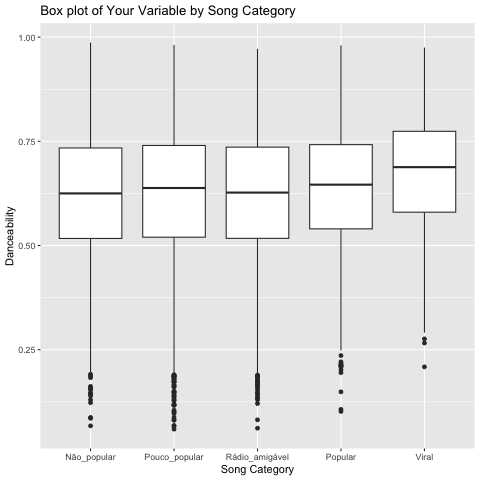

In [143]:
%%R
##Variavel Danceability
ggplot(data, aes(x = song_category, y = danceability
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Danceability")

##Não são eliminados outliers nesta variavel

In [149]:

%%R
## 51/18831 = 0.003 percentagem de elementos removidos do dataset. 
## Limpeza muito minuciosa e pormenorizada.

#### Estamos em condições de aplicar as metodologias. 

df_VAR <- data.frame(data)

  song_popularity song_duration_ms acousticness danceability energy
1              73           262333     0.005520        0.496  0.682
2              66           216933     0.010300        0.542  0.853
3              76           231733     0.008170        0.737  0.463
4              74           216933     0.026400        0.451  0.970
5              56           223826     0.000954        0.447  0.766
6              80           235893     0.008950        0.316  0.945
  instrumentalness key liveness loudness audio_mode speechiness   tempo
1         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
2         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
3         4.47e-01   0   0.2550   -7.828          1      0.0792 123.881
4         3.55e-03   0   0.1020   -4.938          1      0.1070 122.444
5         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
6         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
  time_signature aud

In [159]:
# Importar o DataFrame de R para Python
df_VAR = %R df_VAR



In [161]:
df_VAR.set_index(pd.RangeIndex(start=1, stop=len(df_VAR)+1, step=1), inplace=True)

In [162]:
df_VAR

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_category
1,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474,Popular
2,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370,Popular
3,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324,Popular
4,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198,Popular
5,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574,Rádio_amigável
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14841,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300,Rádio_amigável
14842,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265,Rádio_amigável
14843,23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286,Não_popular
14844,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323,Rádio_amigável


### 6.11. <a id='toc6_11_'></a>[Gráficos comparativos da remoção dos outliers com os diferentes métodos](#toc0_)

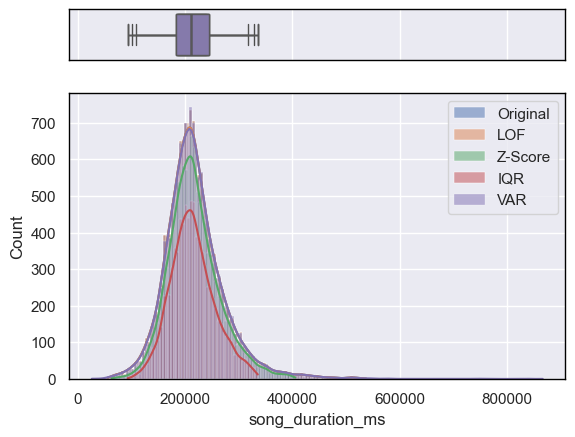

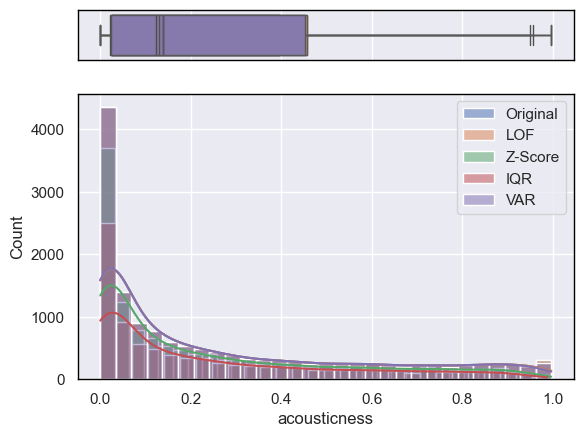

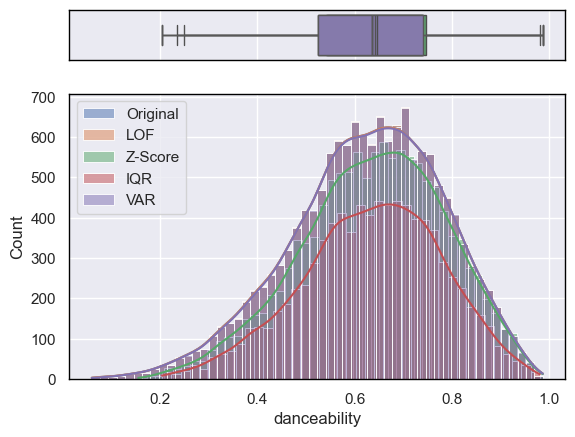

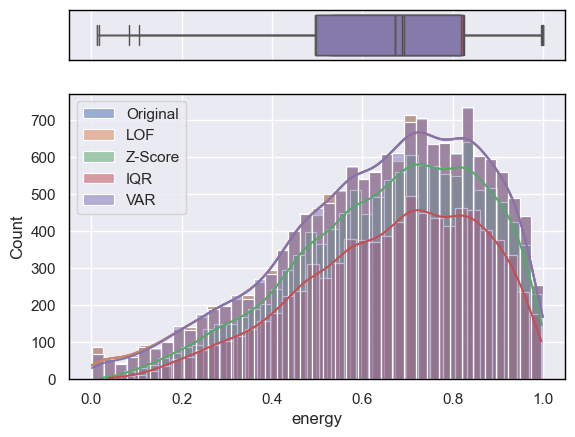

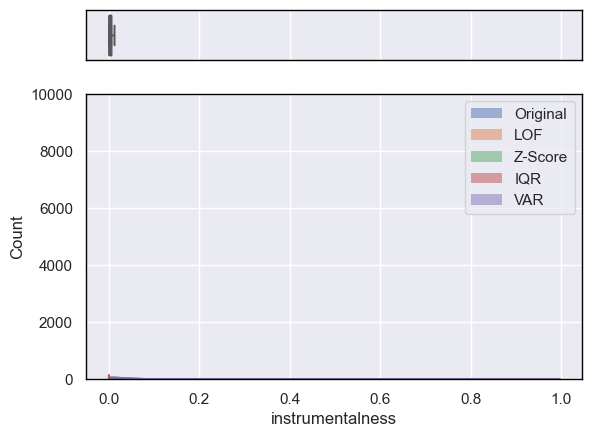

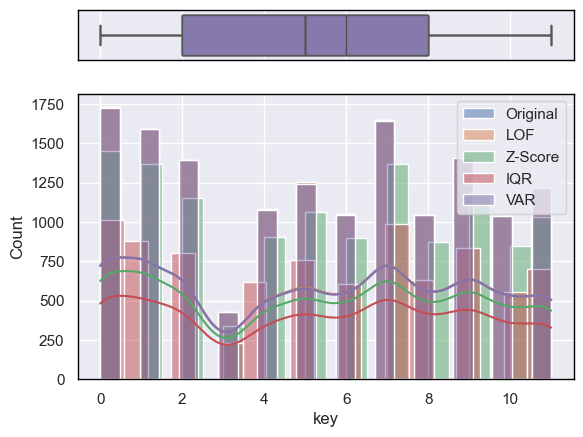

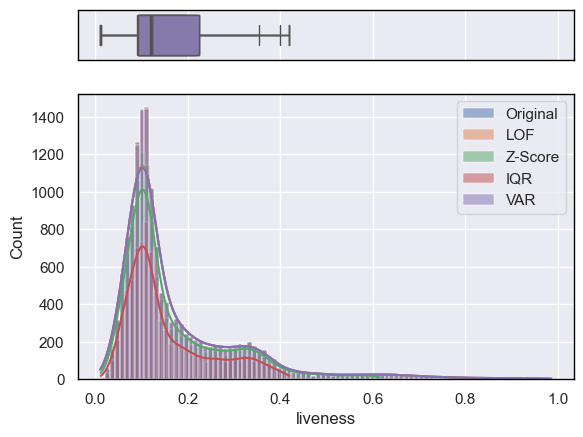

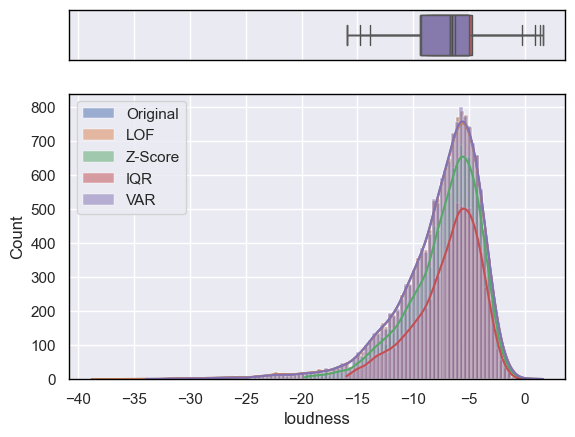

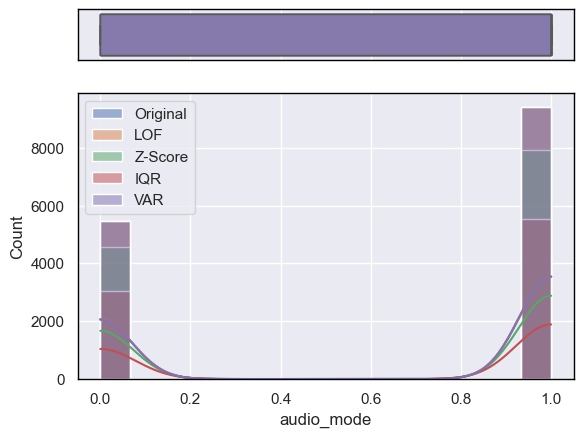

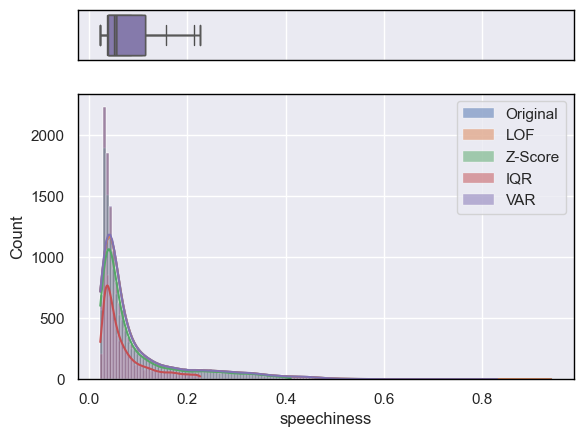

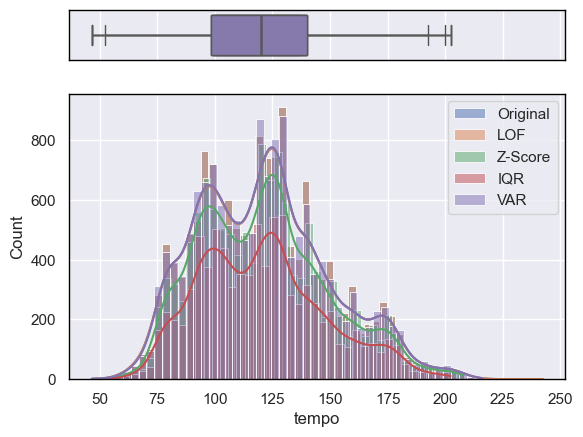

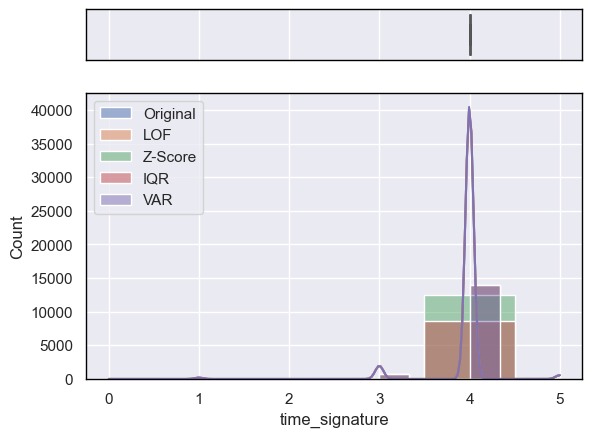

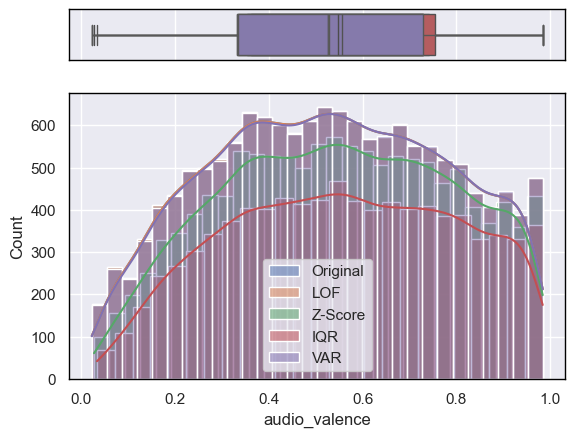

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

variables = X.columns
data_frames = [('Original', X), ('LOF', df_LOF), ('Z-Score', df_Z), ('IQR', df_IQR), ('VAR', df_VAR)]

for variable in variables:
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    for label, df in data_frames:
        sns.boxplot(x=df[variable], orient="h", ax=ax_box, whis=1.5, showfliers=False)
        sns.histplot(data=df, x=variable, ax=ax_hist, kde=True, label=label)
    
    ax_box.set(xlabel='')
    ax_hist.legend()
    
    # Adicionando borda preta em torno de cada imagem
    for ax in [ax_box, ax_hist]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.show()


### 6.12. <a id='toc6_12_'></a>[Inferência](#toc0_)

Conjunto de dados inicial: 18835 amostras.

Com o método do Intervalo Interquartil: 

Com o método do Z-score:

Com o método do Local Outlier Factor:


### 6.13. <a id='toc6_13_'></a>[Estatísticas do dataset](#toc0_)

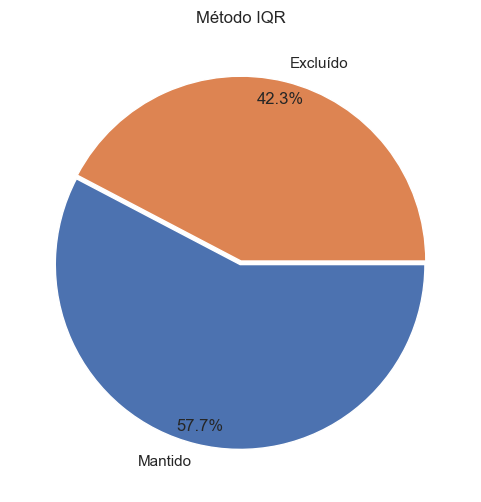

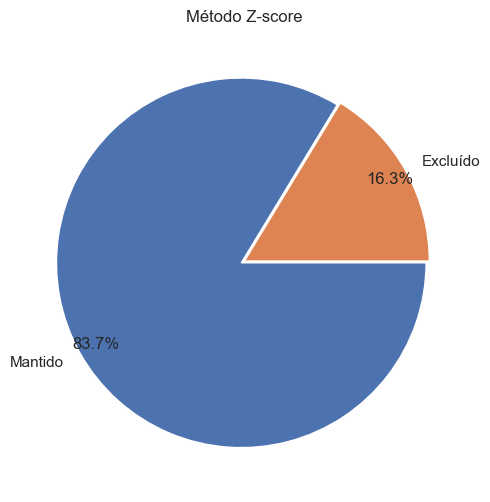

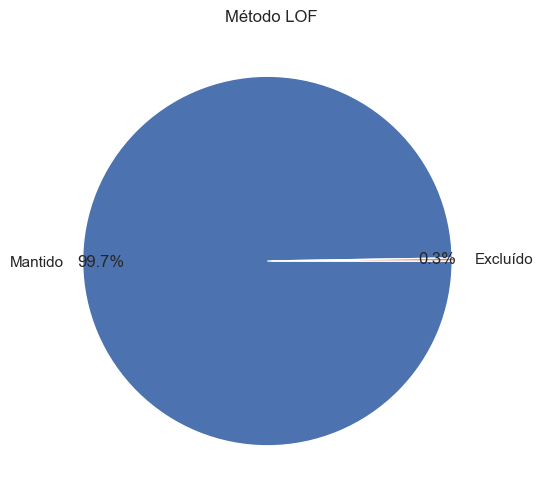

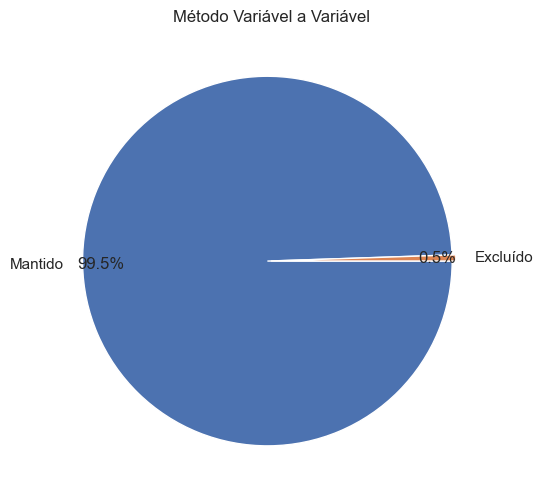

In [407]:
import matplotlib.pyplot as plt

# Definindo as cores
sns.set_theme(style="darkgrid")

methods = [('Método IQR', df_IQR), ('Método Z-score', df_Z), ('Método LOF', df_LOF), ('Método Variável a Variável', df_VAR)]

for title, df in methods:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.pie([df.shape[0], df_raw.shape[0] - df.shape[0]],
           radius=1,
           labels=['Mantido', 'Excluído'],
           counterclock=False,
           autopct='%1.1f%%',
           pctdistance=0.9,
           explode=[0.02, 0],
           shadow=False)
    plt.show()


## 7. <a id='toc7_'></a>[Implementação de algoritmos de Aprendizagem Computacional](#toc0_)

### 7.1. <a id='toc7_1_'></a>[Random Forest](#toc0_)

#### 7.1.1. <a id='toc7_1_1_'></a>[Divisão das variáveis dependentes e independentes](#toc0_)

In [418]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    m = [i.replace(' ','_') for i in df.columns.values]
    df.columns = m
    X = df[['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature', 'audio_valence']]
    X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
    Y = df["song_popularity"]
    return X, Y

#### 7.1.2. <a id='toc7_1_2_'></a>[Divisão em conjunto de treino e conjunto de teste](#toc0_)

In [421]:
# Lista de dados e etiquetas
conjuntos_dados = [(df_IQR, "IQR"), (df_Z, "Z"), (df_LOF, "LOF"), (df_VAR, "VAR")]

# Escolha o conjunto de dados que deseja processar (por exemplo, o 3º conjunto de dados)
indice_selecionado = 2
df_selecionado, nome_selecionado = conjuntos_dados[indice_selecionado]

X, Y = preprocess_data(df_selecionado)

# Divisão dos dados em conjuntos de treinamento e teste
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
Train_X.reset_index(drop=True, inplace=True)

print('Conjunto original (100%) para', nome_selecionado, ': ', X.shape, Y.shape)
print('Conjunto de treino (80%) para', nome_selecionado, ': ', Train_X.shape, Train_Y.shape)
print('Conjunto de teste (20%) para', nome_selecionado, ': ', Test_X.shape, Test_Y.shape)

Conjunto original (100%) para LOF :  (14885, 13) (14885,)
Conjunto de treino (80%) para LOF :  (11908, 13) (11908,)
Conjunto de teste (20%) para LOF :  (2977, 13) (2977,)


#### 7.1.3. <a id='toc7_1_3_'></a>[Treino inicial do modelo](#toc0_)

In [422]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config

# Escolha RandomForestClassifier para problemas de classificação e RandomForestRegressor para regressão
model = make_pipeline(RandomForestRegressor(random_state=21))  # ou RandomForestRegressor
set_config(display='diagram')

# Treinar o modelo
model.fit(Train_X, Train_Y)

# Fazer previsões
Pred_Y = model.predict(Test_X)
model



In [188]:
def modelresults(predictions):
    mae = mean_absolute_error(Test_Y, predictions)
    mse = mean_squared_error(Test_Y, predictions)
    r2 = r2_score(Test_Y, predictions)
    
    print('Erro absoluto médio do modelo: {:.4f}'.format(mae))
    print('')
    print('Erro quadrático médio do modelo: {:.4f}'.format(mse))
    print('')
    print('O valor de r2 do modelo: {:.4f}'.format(r2))

#### 7.1.4. <a id='toc7_1_4_'></a>[Esquema árvore](#toc0_)

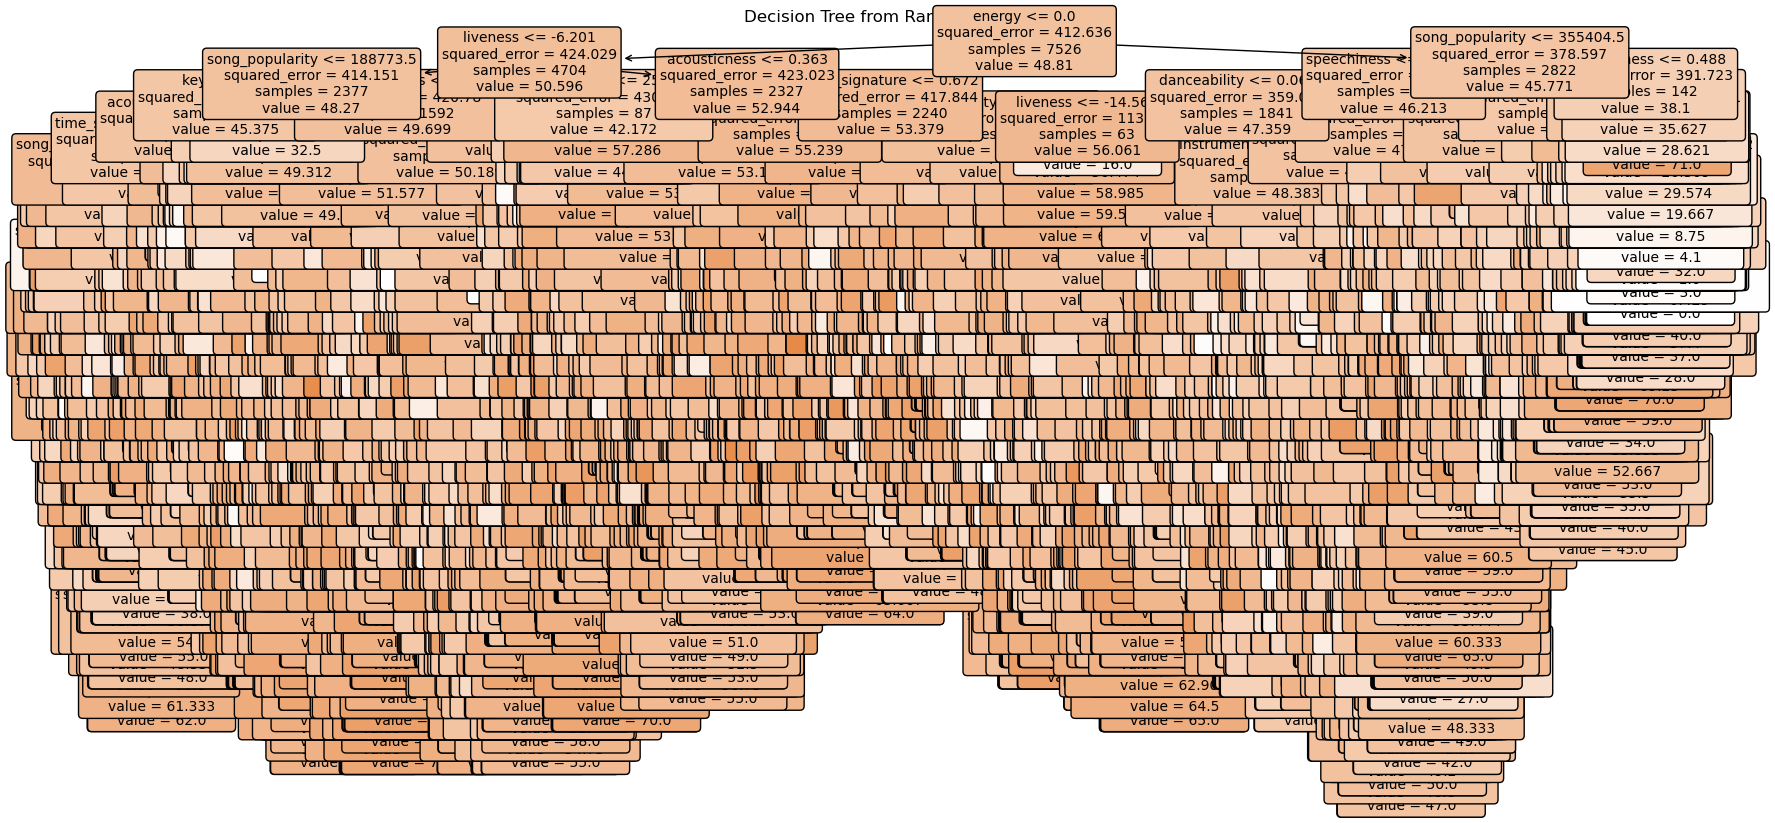

In [190]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
 
# Assuming model is your trained Pipeline
# Accessing the last step in the pipeline which should be your RandomForestRegressor
random_forest = model.steps[-1][1]

# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = random_forest.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df_LOF.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()


#### 7.1.5. <a id='toc7_1_5_'></a>[Performance](#toc0_)

In [189]:
modelresults(Pred_Y)

Erro absoluto médio do modelo: 16.1162

Erro quadrático médio do modelo: 414.6477

O valor de r2 do modelo: 0.0045


#### 7.1.6. <a id='toc7_1_6_'></a>[Matriz de confusão](#toc0_)

#### 7.1.7. <a id='toc7_1_7_'></a>[Afinação dos hiperparâmetros com o Grid Search Cross Validation](#toc0_)

In [191]:
param_grid = {
    'n_estimators': [100],      # Número de árvores in the forest
    'max_features': ['sqrt', 'log2'],     # Número de features a serem consideradas para divisão
    'max_depth': [None, 10],      # Profundidade máxima da árvore
    'min_samples_split': [2, 5],      # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2]         # Número mínimo de amostras num nó folha
}


#### 7.1.8. <a id='toc7_1_8_'></a>[Configurar e executar o Grid Search Cross Validation](#toc0_)

In [192]:
# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=21), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Executar o GridSearchCV
grid_search.fit(Train_X, Train_Y)

# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(f"Melhor estimador: {best_estimator}")
print(f'Melhores hiperparâmetros: {best_params}')


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END max_depth=None,

#### 7.1.9. <a id='toc7_1_9_'></a>[Treino do modelo com os melhores hiperparâmetros](#toc0_)

In [193]:
# Criar um novo modelo com os melhores hiperparâmetros
#best_model = RandomForestClassifier(**best_params, random_state=42)  # ou RandomForestRegressor
best_model = RandomForestRegressor(**best_params, random_state=42)  # ou RandomForestRegressor

# Treinar o modelo
best_model.fit(Train_X, Train_Y)

# Fazer previsões
Best_Pred_Y = best_model.predict(Test_X)


In [194]:
modelresults(Best_Pred_Y)

Erro absoluto médio do modelo: 15.7624

Erro quadrático médio do modelo: 394.2467

O valor de r2 do modelo: 0.0535


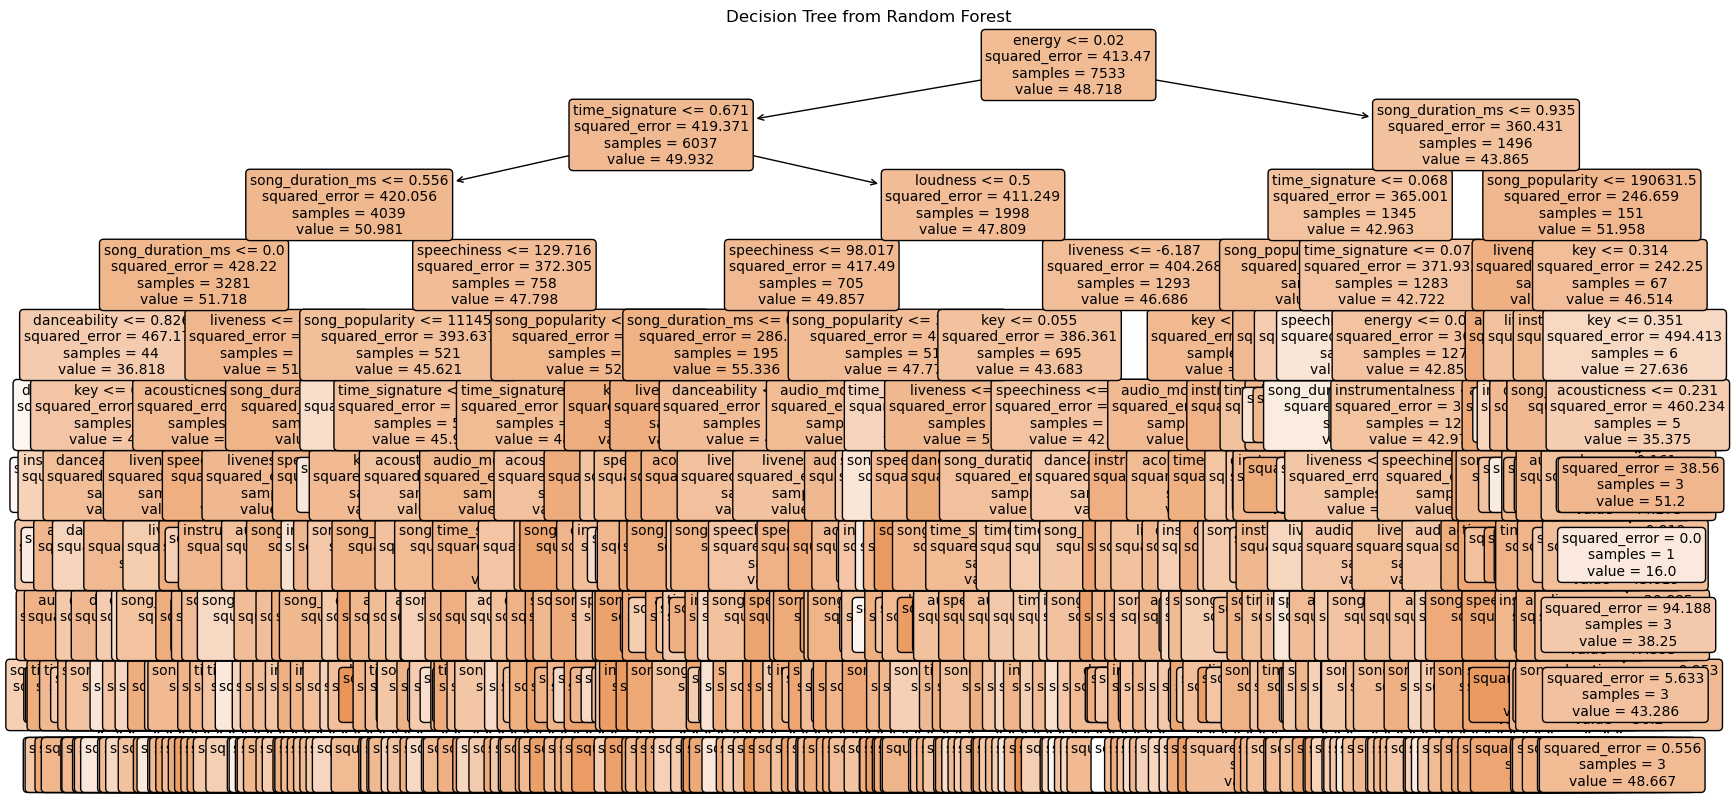

In [196]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming best_model is your trained RandomForestRegressor
random_forest = best_model

# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = random_forest.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df_LOF.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Best_Pred_Y, Pred_Y),
                              display_labels=df_LOF.columns) 
cm.plot()

### 7.2. <a id='toc7_2_'></a>[Árvore de Regressão](#toc0_)

As árvores de decisão são modelos baseados em conjunções e disjunções de regras que podem facilmente ser representadas sob a forma de uma árvore. 
Neste trabalho utiliso arvore de decisão para resolver um problema de Regressão (arvore de regressão).

Consideremos os dados "Song popularity Data" do "Kaggle", pretende-se criar um modelo preditivo da popularidade de musicas "Song popularity Data" com base em determinadas variaveis como a energia, a acustica, a instrumentalidade, a vivacidade, entre outros. A arvore de regressao é guiado pelo RMSE e não por medidas de impureza.

#### 7.2.1. <a id='toc7_2_1_'></a>[Existem diferentes pacotes para modelar com árvores de decisão. Aqui usaremos o tree.](#toc0_)

In [276]:
%%R
library(readr) #clamar o pacote readr
install.packages("tree") #instalar o pacote tree (diz se a arvore é de classificação ou de regressão)
library(tree) #chamar o pacote tree


The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpqYzXIF/downloaded_packages


trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/tree_1.0-43.tgz'
Content type 'application/gzip' length 183668 bytes (179 KB)
downloaded 179 KB



In [277]:
%%R -i df_LOF
song_data <- df_LOF

In [278]:
%%R
# Vamos eliminar a primeira coluna nos dados

song_data1=song_data
head(song_data1)

  song_popularity

 song_duration_ms acousticness danceability energy
1              73           262333     0.005520        0.496  0.682
2              66           216933     0.010300        0.542  0.853
3              76           231733     0.008170        0.737  0.463
4              74           216933     0.026400        0.451  0.970
5              56           223826     0.000954        0.447  0.766
6              80           235893     0.008950        0.316  0.945
  instrumentalness key liveness loudness audio_mode speechiness   tempo
1         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
2         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
3         4.47e-01   0   0.2550   -7.828          1      0.0792 123.881
4         3.55e-03   0   0.1020   -4.938          1      0.1070 122.444
5         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
6         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
  time_signature audio_valence
1     

#### 7.2.2. <a id='toc7_2_2_'></a>[Vamos dividir o conjunto de dados em dados de treio e de teste.](#toc0_)

In [279]:
%%R

#___________
set.seed(1234) #fazer a mesma divisão dos conjuntos de teste e
#treino sempre que se executa o código
ind.tr=sample(1:nrow(song_data1),0.8*nrow(song_data))
song.tr=song_data1[ind.tr,] #Dados para treino
song.te=song_data1[-ind.tr,] #Dados para teste


#### 7.2.3. <a id='toc7_2_3_'></a>[Ajustamos uma árvore de regressão:](#toc0_)

In [280]:
%%R

song.tree=tree(song_popularity~.,data=song.tr) #ajusta uma árvore
summary(song.tree) # faz um resumo da árvore ajustada


Regression tree:
tree(formula = song_popularity ~ ., data = song.tr)
Variables actually used in tree construction:
[1] "instrumentalness"
Number of terminal nodes:  2 
Residual mean deviance:  409.4 = 4874000 / 11910 
Distribution of residuals:
   Min. 1st Qu. 

 Median    Mean 3rd Qu.    Max. 
-50.590 -11.590   3.415   0.000  14.410  50.870 


A função tree identificou automaticamente que se trata de um problema de regressao  e as variâveis que ganharam os nós para construir a árvore são "instrumentalness", "loudness" e "energy"  . De facto, as árvores de decisão têm esta vantagem: apenas utilizam as variáveis essenciais para resolver o problema (efetuam uma seleção de variáveis). A árvore contém 4 folhas e tem um erro de treino de cerca de 455 em Média.

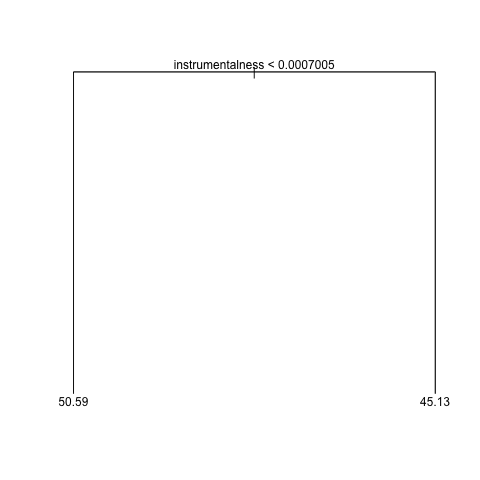

In [281]:
%%R
plot(song.tree) #Apresenta as linhas da árvore
text(song.tree,pretty=0)#acrescenta  as variáveis que ganharam cara nó e as condições

#### 7.2.4. <a id='toc7_2_4_'></a>[O PROCESSO DE PODA](#toc0_)

Avaliamos agora a possibilidade de obter ganhos com a poda da árvore:

In [282]:
%%R
song.tree.cv=cv.tree(song.tree) #aplica o processo da poda
song.tree.cv # faz um resumo do processo aplicado

$size
[1] 2 1

$dev
[1] 4887737 4953939

$k
[1]     -Inf 78873.94

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"


Neste caso, a árvore original é a de melhor performance (ela apresenta menor erro com 4 folhas), pelo que não se aplica qualquer estratégia de poda.
Podemos assim avaliar no conjunto de teste:

In [283]:
%%R
pred=predict(song.tree,newdata=song.te) #avalia o madelo criado no conjunto de teste.
sqrt(mean((pred-song.te$song_popularity)^2))# calcula RMSE (podemos utilizar o MAPE para obter os erros em percentágens)

[1] 20.16712


#### 7.2.5. <a id='toc7_2_5_'></a>[A ÁRVIRE TMAX](#toc0_)

Mas, e se os critérios de paragem pré-estabelecidos no R são demasiado exigentes? Poderá a árvore construída com 4 folhas não ser a melhor porque o processo de construção terminou cedo demais? Podemos sempre forçar a árvore Tmax e aplicar a estratégia de poda.

In [284]:
%%R
song.tmax=tree(song_popularity~.,data=song.tr, control = tree.control(nrow(song.tr),mindev=0.0005,minsize=2))
# mindev- controla o erro mínimo após a divisão.
#minsize-define o tamanho mínimo do nó antes da divisão.~
summary(song.tmax)# ap



Regression tree:
tree(formula = song_popularity ~ ., data = song.tr, control = tree.control(nrow(song.tr), 
    mindev = 5e-04, minsize = 2))
Number of terminal nodes:  272 
Residual mean deviance:  327.5 = 3810000 / 11640 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-58.380 -10.280   2.205   0.000  12.620  51.710 


 A árvore obtida tem 350 folhas e um erro de aproximadamente  307. Á seguir temos duas representações em que apenas uma apresenta as variáveis que ganhou cada nó.

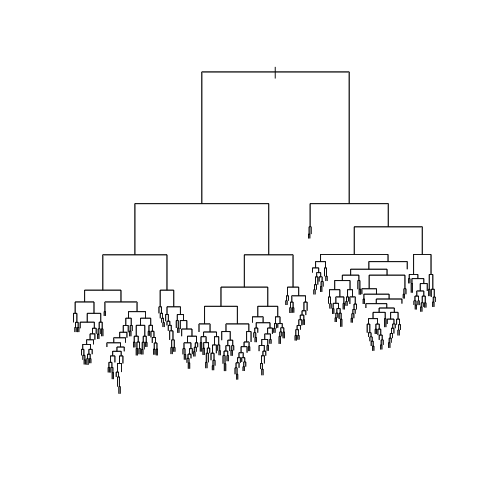

In [285]:
%%R
plot(song.tmax) #Apresenta as linhas da árvore

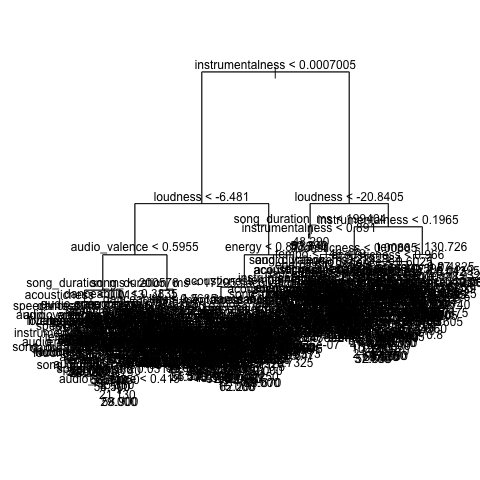

In [286]:
%%R
plot(song.tmax) #Apresenta as linhas da árvore
text(song.tmax,pretty=0)#acrescenta  as variáveis que ganharam cara nó e as condições.

#### 7.2.6. <a id='toc7_2_6_'></a>[A PODA DA ÁRVIRE TMAX](#toc0_)

Aplicamos agora a estratégia de poda:

In [287]:
%%R
song.tmax.cv=cv.tree(song.tmax) #aplica a poda
song.tmax.cv # faz um resumo da processo de poda

$size
  [1] 272 271 270 269 268 267 266 265 264 263 261 260 259 257 256 254 252 251
 [19] 249 248 247 246 242 241 240 236 234 233 232 231 230 229 228 227 226 225
 [37] 224 222 217 216 215 214 213 210 209 208 206 205 204 202 201 200 193 189
 [55] 188 187 185 184 183 180 177 176 175 174 173 172 167 166 165 162 156 155
 [73] 154 153 152 150 149 148 147 146 142 139 138 136 135 134 133 124 120 119
 [91] 118 116 106 105 102 100  99  98  87  82  79  75  74  73  71  70  65  61
[109]  60  59  58  57  56  55  53  52  51  50  49  44  43  40  39  37  35  32
[127]  31  30  29  26  22  21  20  19  18  16  15  14  13  12  11  10   9   8
[145]   7   5   4   3   2   1

$dev
  [1] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [10] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [19] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [28] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [37] 4884884 4884884 

Como podemos observar, entre 4 e 350 folhas a quantidade de erro é sempre a mesma (6044785) tornando- se óbvio que a árvore com 4 folhas tem a mesma performance 350 folhas. Vejamos este resultado no gráfico que se segue:

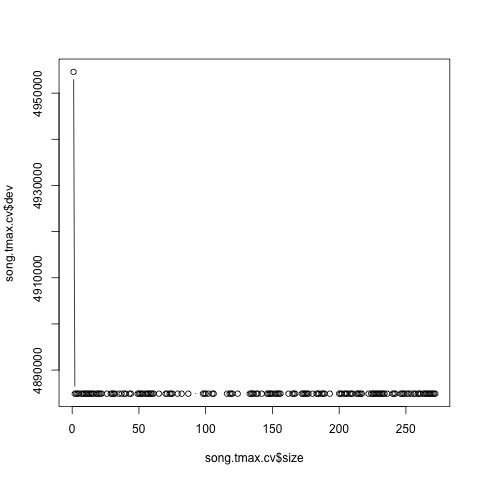

In [288]:
%%R
plot(song.tmax.cv$size,song.tmax.cv$dev,type="b")
#O comando "type" especifica o tipo de gráfico. Neste caso, "b" 
#indica que quero um gráfico de disperssão com linhas conectando
#os pontos.

Já sabemos que entre perfórmances semelhantes é preferível o modelo mais ssímples.
Portanto, devemos podar a árvore de forma que fique com apenas 4 folhas.

Vamos aplicar a poda.

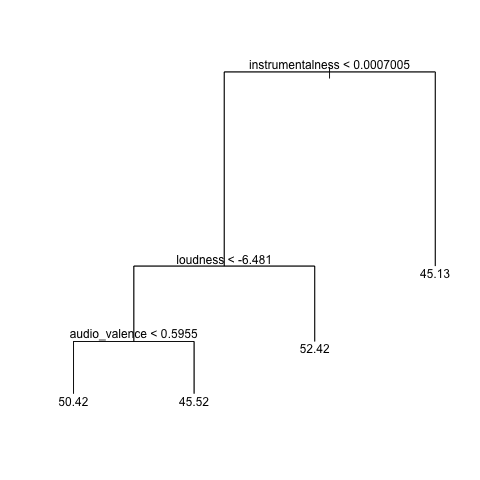

In [289]:
%%R
prune.song.tmax.tree = prune.tree(song.tmax, best = 4, method = "deviance") # aplicar a pode de forma que a árvore podada tenha 4 folhas, conforme indicado no processo.
plot(prune.song.tmax.tree) #Apresenta as linhas da árvore
text(prune.song.tmax.tree,pretty=0) #acrescenta  as variáveis que ganharam cara nó e as condições.

Cocluimos que a árvore óptima tem mesmo quatro folhas.

### 7.3. <a id='toc7_3_'></a>[Bagging](#toc0_)

In [311]:
%%R
install.packages("pls")
library(pls)
library(psych) 
library(readr)
library(tree)
library(caret)
library(gbm)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(pROC)
library(ggplot2)
library(reshape2)


The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpqYzXIF/downloaded_packages


trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/pls_2.8-3.tgz'
Content type 'application/gzip' length 1183010 bytes (1.1 MB)
downloaded 1.1 MB



In [312]:
%%R -i df_LOF
data <- df_LOF
data.numeric <- data[,sapply(data, is.numeric)]

In [313]:
%%R
# BAGGING
ind.tr=sample(1:nrow(data),0.6*nrow(data))
data.tr=data[ind.tr,]
data.te=data[-ind.tr,]

In [314]:
%%R
library(randomForest)
head(data.tr)
song.bagg1 = randomForest(song_popularity ~ ., data = data.tr, 
                          mtry = (ncol(data.tr) - 1))
song.bagg1


Call:
 randomForest(formula = song_popularity ~ ., data = data.tr, mtry = (ncol(data.tr) -      1)) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 406.6963
                    % Var explained: 3.1


In [315]:
%%R
# Prever os valores de popularidade das músicas no conjunto de dados de teste
pred=predict(song.bagg1,newdata=data.te)
# RMSE
sqrt(mean((pred-data.te$song_popularity)^2))

[1] 19.85597


In [316]:
%%R
## Bagging para 2000 árvores

song.bagg2 = randomForest(song_popularity ~ ., data = data.tr, 
                          mtry = (ncol(data.tr) - 1), ntree = 2000)
song.bagg2



Call:
 randomForest(formula = song_popularity ~ ., data = data.tr, mtry = (ncol(data.tr) -      1), ntree = 2000) 
               Type of random forest: regression
                     Number of trees: 2000
No. of variables tried at each split: 13

          Mean of squared residuals: 404.8689
                    % Var explained: 3.54


In [330]:
%%R
# Prever os valores de popularidade das músicas no conjunto de dados de teste
pred=predict(song.bagg2,newdata=data.te)
# RMSE
sqrt(mean((pred-data.te$song_popularity)^2))

Error in predict.randomForest(song.bagg1, newdata = data.te) : 
  New factor levels not present in the training data


RInterpreterError: Failed to parse and evaluate line '# Prever os valores de popularidade das músicas no conjunto de dados de teste\npred=predict(song.bagg1,newdata=data.te)\n# RMSE\nsqrt(mean((pred-data.te$song_popularity)^2))\n'.
R error message: 'Error in predict.randomForest(song.bagg1, newdata = data.te) : \n  New factor levels not present in the training data'

In [318]:
%%R
############# CATEGORIZAÇÃO DOS DADOS ##################

breaks <- c(0, 35, 60, 100)
labels <- c("Não_popular","Rádio_amizade","Popular")
data$song_category <- cut(data$song_popularity, breaks = breaks, labels = labels, include.lowest = TRUE)
head(data)
data
dim(data)

data$song_popularity <- NULL
data$song_name<-NULL
head(data)
summary(data$song_category)

str(data)
dim(data)
head(data)

'data.frame':	14885 obs. of  14 variables:
 $ song_duration_ms: int  262333 216933 231733 216933 223826 235893 199893 213800 222586 203346 ...
 $ acousticness    : num  0.00552 0.0103 0.00817 0.0264 0.000954 ...
 $ danceability    : num  0.496 0.542 0.737 0.451 0.447 0.316 0.581 0.613 0.33 0.542 ...
 $ energy          : num  0.682 0.853 0.463 0.97 0.766 0.945 0.887 0.953 0.936 0.905 ...
 $ instrumentalness: num  2.94e-05 0.00 4.47e-01 3.55e-03 0.00 ...
 $ key             : int  8 3 0 0 10 4 4 2 1 9 ...
 $ liveness        : num  0.0589 0.108 0.255 0.102 0.113 0.396 0.268 0.152 0.0926 0.136 ...
 $ loudness        : num  -4.09 -6.41 -7.83 -4.94 -5.07 ...
 $ audio_mode      : int  1 0 1 1 1 0 0 1 1 1 ...
 $ speechiness     : num  0.0294 0.0498 0.0792 0.107 0.0313 0.124 0.0624 0.0855 0.0917 0.054 ...
 $ tempo           : num  167 105 124 122 172 ...
 $ time_signature  : int  4 4 4 4 4 4 4 4 4 4 ...
 $ audio_valence   : num  0.474 0.37 0.324 0.198 0.574 0.32 0.724 0.537 0.234 0.374 ...
 $ so

In [319]:
%%R
##################### BAGGING com os dados organizados ###############

sapply(data, class)
data$song_category=as.factor(data$song_category)
data$time_signature=as.factor(data$time_signature)
data$audio_mode=as.factor(data$audio_mode)

In [320]:
%%R
library(readr)
set.seed(1234)
ind.tr=sample(1:nrow(data),0.7*nrow(data))
data.tr=data[ind.tr,]
data.te=data[-ind.tr,]

In [321]:
%%R
library(randomForest)
head(data.tr)
song.bagg=randomForest(song_category~.,data=data.tr,mtry=(ncol(data.tr)-1))
song.bagg


Call:
 randomForest(formula = song_category ~ ., data = data.tr, mtry = (ncol(data.tr) -      1)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 13

        OOB estimate of  error rate: 52.69%
Confusion matrix:
              Não_popular Rádio_amizade Popular class.error
Não_popular           239          1732     431   0.9004996
Rádio_amizade         273          3559     950   0.2557507
Popular               145          1959    1131   0.6503864


In [322]:
%%R
pred=predict(song.bagg,newdata=data.te,type="class")
pred1=predict(song.bagg,newdata=data.te,type="prob")
caret::confusionMatrix(pred,data.te$song_category)

Confusion Matrix and Statistics

               Reference
Prediction      Não_popular Rádio_amizade Popular
  Não_popular           105           118      69
  Rádio_amizade         733          1545     871
  Popular               188           378     459

Overall Statistics
                                         
               Accuracy : 0.4722         
                 95% CI : (0.4575, 0.487)
    No Information Rate : 0.457          
    P-Value [Acc > NIR] : 0.02136        
                                         
                  Kappa : 0.1068         
                                         
 Mcnemar's Test P-Value : < 2e-16        

Statistics by Class:

                     Class: Não_popular Class: Rádio_amizade Class: Popular
Sensitivity                     0.10234               0.7570         0.3281
Specificity                     0.94564               0.3386         0.8155
Pos Pred Value                  0.35959               0.4906         0.4478
Neg Pred Value   

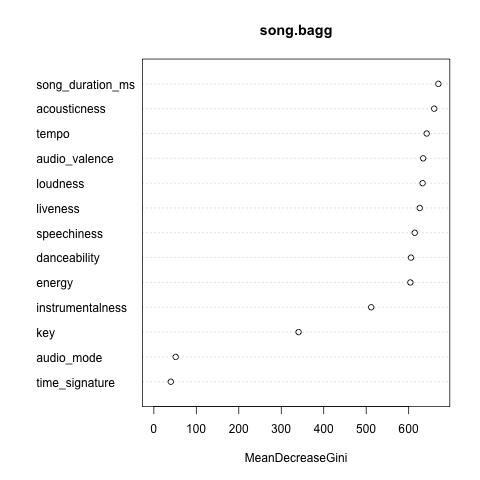

In [323]:
%%R
varImpPlot(song.bagg)

In [324]:
%%R
head(pred1)
roc_curves <- multiclass.roc(data.te$song_category, pred1)
# Calculate AUC
auc_score <- auc(roc_curves)
# Print AUC (curva ROC)
print(auc_score) ## o print diz que em 61% o classificador clasifica bem. 

Multi-class area under the curve: 0.595


JUSTIFICAÇÃO DE RESULTADOS

Os dados são muito semelhantes e as variáveis com mais peso para a classificação são song_duration e acousticness e são semelhantes. 

In [325]:
%%R
median(data$song_duration_ms[data$song_category == "Not_popular"])/60000
median(data$song_duration_ms[data$song_category == "Radio_friendly"])/60000
median(data$song_duration_ms[data$song_category == "Popular"])/60000

[1] 3.568125


In [326]:
%%R
median(data$acousticness[data$song_category == "Not_popular"])
median(data$acousticness[data$song_category == "Radio_friendly"])
median(data$acousticness[data$song_category == "Popular"])

[1] 0.12


In [327]:
%%R
mean(data$loudness[data$song_category == "Not_popular"])
mean(data$loudness[data$song_category == "Radio_friendly"])
mean(data$loudness[data$song_category == "Popular"])

[1] -7.128396


In [328]:
%%R
median(data$loudness[data$song_category == "Not_popular"])
median(data$loudness[data$song_category == "Radio_friendly"])
median(data$loudness[data$song_category == "Popular"])

[1] -6.2235


## 8. <a id='toc8_'></a>[Resultados](#toc0_)

## 9. <a id='toc9_'></a>[Considerações finais](#toc0_)